# AG News Sentimental Classification Task

Fine tuning distilbert-base-uncased model to classify news text into four classes: World, Sports, Business, and Sci/Tech.

In [ ]:
# To make the dataset load in google colab without error
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

ds = load_dataset("fancyzhx/ag_news")
ds

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [ ]:
import pandas as pd

df = pd.DataFrame(ds["train"])
df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [ ]:
df["label"].unique()

array([2, 3, 1, 0])

In [ ]:
labels = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

In [ ]:
print(f"Text: { df['text'][0] }")
print(f"Label: { labels[df['label'][0]] }")

Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Label: Business


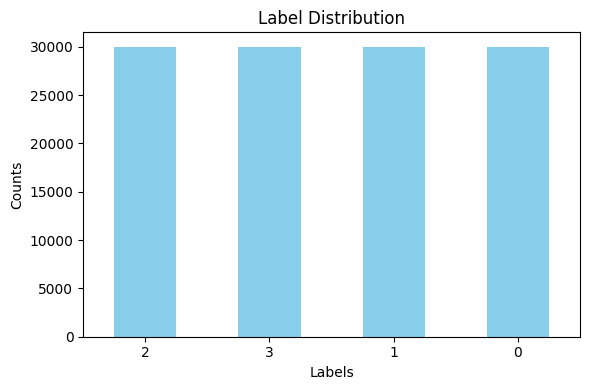

In [ ]:
import matplotlib.pyplot as plt


label_counts = df["label"].value_counts()

plt.figure(figsize=(6, 4))
label_counts.plot(kind="bar", color="skyblue")

plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

In [ ]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

final_ds = DatasetDict({
    "train": train_ds.remove_columns("__index_level_0__"),
    "test": test_ds.remove_columns("__index_level_0__"),
    "eval": ds["test"]
})

final_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 96000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 24000
    })
    eval: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [ ]:
model = "distilbert-base-uncased"

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model)

def preprocessing(data):
    return tokenizer(data["text"], truncation=True, padding="longest")

tokenized_ds = ds.map(preprocessing, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model, num_labels=4)
model

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=predictions, references=labels, average="macro")["f1"],
        "f1_weighted": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
    }

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/my_model_checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="wandb",
    learning_rate=1e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=10,
    disable_tqdm=False,
    warmup_ratio=0.1,                          # Helps stabilize early training
    max_grad_norm=1.0,                         # Clips gradient to avoid spikes
    fp16=True                                  # Mixed precision for stability + speed (GPU only)
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-38-2916210193.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.153200,0.216665,0.932237,0.932331,0.932331
2,0.085800,0.191335,0.941316,0.941437,0.941437
3,0.068200,0.201479,0.942237,0.942278,0.942278


TrainOutput(global_step=5625, training_loss=0.09020792372491625, metrics={'train_runtime': 2895.8315, 'train_samples_per_second': 124.317, 'train_steps_per_second': 1.942, 'total_flos': 3.438184802319053e+16, 'train_loss': 0.09020792372491625, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.2014794498682022, 'eval_accuracy': 0.9422368421052632, 'eval_f1_macro': 0.9422782645902603, 'eval_f1_weighted': 0.9422782645902603, 'eval_runtime': 16.0414, 'eval_samples_per_second': 473.774, 'eval_steps_per_second': 7.418, 'epoch': 3.0}


In [ ]:
score_metrics = {k: v for k, v in results.items() if "accuracy" in k or "f1" in k or "loss" in k}
performance_metrics = {k: v for k, v in results.items() if k not in score_metrics and k != "epoch"}

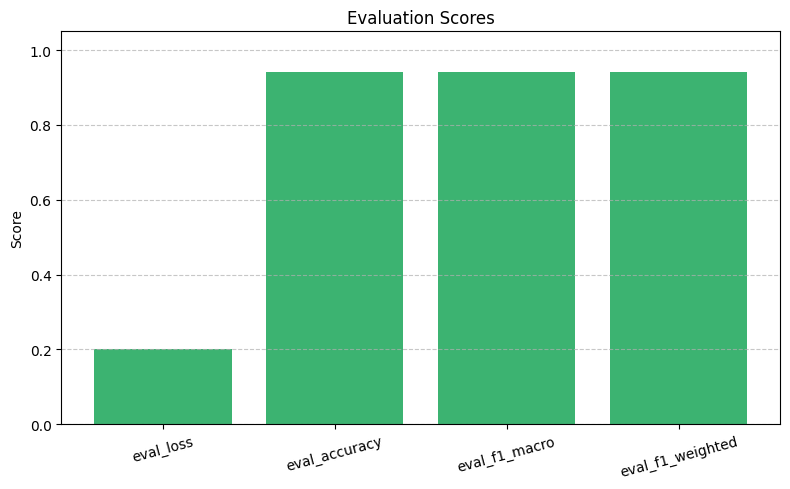

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(score_metrics.keys(), score_metrics.values(), color="mediumseagreen")
plt.ylabel("Score")
plt.title("Evaluation Scores")
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

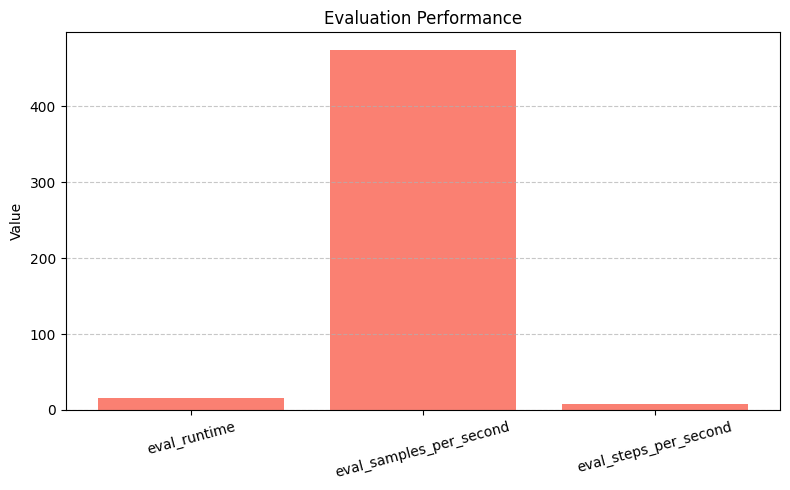

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(performance_metrics.keys(), performance_metrics.values(), color="salmon")
plt.ylabel("Value")
plt.title("Evaluation Performance")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [ ]:
tokenized_test_ds = final_ds["eval"].map(preprocessing, batched=True)

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
tokenized_test_ds

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 7600
})

In [ ]:
predictions = trainer.predict(tokenized_test_ds)
logits = predictions.predictions
predicted_classes = np.argmax(logits, axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score


accuracy = accuracy_score(final_ds["eval"]["label"], predicted_classes)

print(f"Total Accuracy Percentage: {accuracy * 100:.2f}%\n")
print(classification_report(final_ds["eval"]["label"], predicted_classes))

Total Accuracy Percentage: 94.22%

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1900
           1       0.99      0.98      0.99      1900
           2       0.92      0.90      0.91      1900
           3       0.91      0.93      0.92      1900

    accuracy                           0.94      7600
   macro avg       0.94      0.94      0.94      7600
weighted avg       0.94      0.94      0.94      7600



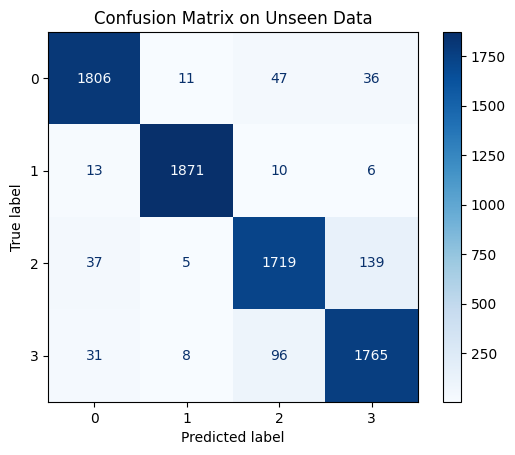

In [ ]:
cm = confusion_matrix(final_ds["eval"]["label"], predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Unseen Data")
plt.show()

In [ ]:
for i, (text, true, pred) in enumerate(zip(final_ds["eval"]["text"], final_ds["eval"]["label"], predicted_classes)):
    if i >= 100:
        break
    print(f"Text: { text }\nTrue Label: { labels[true] } | Predicted: { labels[int(pred)] }\n")


Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
True Label: Business | Predicted: Business

Text: The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
True Label: Sci/Tech | Predicted: Sci/Tech

Text: Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.
True Label: Sci/Tech | Predicted: Sci/Tech

Text: Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts hi

In [ ]:
!huggingface-cli login


    _
    _
    _
    _
    _

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
The token `First Token` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `First Token`


In [ ]:
trainer.push_to_hub("ag_news_fine_tuned_model")

Uploading...:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Arawat99/my_model_checkpoints/commit/c7ac4d6e05c4474a5041e90b3c7c5d153f6d88ae', commit_message='ag_news_fine_tuned_model', commit_description='', oid='c7ac4d6e05c4474a5041e90b3c7c5d153f6d88ae', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Arawat99/my_model_checkpoints', endpoint='https://huggingface.co', repo_type='model', repo_id='Arawat99/my_model_checkpoints'), pr_revision=None, pr_num=None)